In [273]:
# Data Preparation
import pandas as pd

# Load the dataset
file_path = "Electric_Vehicle_Population_Data.csv"
df = pd.read_csv(file_path)


# show the first few rows
print("First 5 rows:")
print(df.head())


# Check unique values in the target variable
print("\nUnique values in Electric Vehicle Type:")
print(df["Electric Vehicle Type"].unique())


# Filter to only BEV and PHEV
df = df[df["Electric Vehicle Type"].isin(["Battery Electric Vehicle (BEV)", "Plug-in Hybrid Electric Vehicle (PHEV)"])]


df = df[df['Electric Range'] > 0]


First 5 rows:
   VIN (1-10)     County       City State  Postal Code  Model Year   Make  \
0  5YJSA1E65N     Yakima    Granger    WA      98932.0        2022  TESLA   
1  KNDC3DLC5N     Yakima     Yakima    WA      98902.0        2022    KIA   
2  5YJYGDEEXL  Snohomish    Everett    WA      98208.0        2020  TESLA   
3  3C3CFFGE1G     Yakima     Yakima    WA      98908.0        2016   FIAT   
4  KNDCC3LD5K     Kitsap  Bremerton    WA      98312.0        2019    KIA   

     Model                   Electric Vehicle Type  \
0  MODEL S          Battery Electric Vehicle (BEV)   
1      EV6          Battery Electric Vehicle (BEV)   
2  MODEL Y          Battery Electric Vehicle (BEV)   
3      500          Battery Electric Vehicle (BEV)   
4     NIRO  Plug-in Hybrid Electric Vehicle (PHEV)   

   Clean Alternative Fuel Vehicle (CAFV) Eligibility  Electric Range  \
0  Eligibility unknown as battery range has not b...             0.0   
1  Eligibility unknown as battery range has not b...  

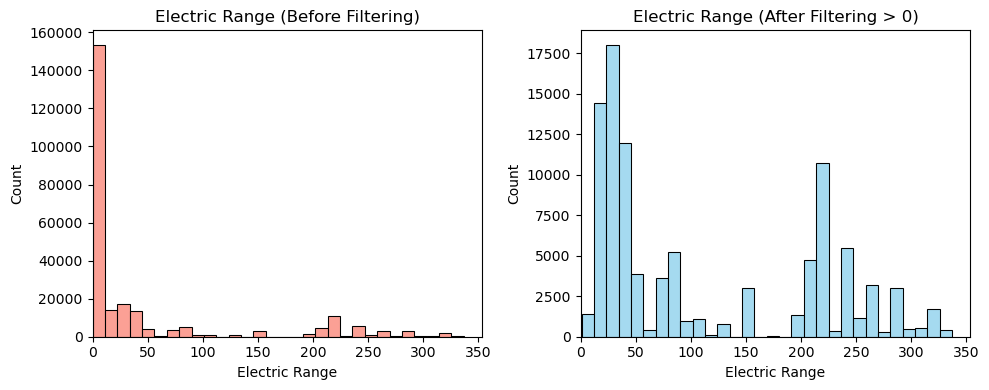

In [275]:
# Visualize Electric Range before and after filtering
import matplotlib.pyplot as plt
import seaborn as sns

# Plot before filtering (use original loaded df)
df_raw = pd.read_csv(file_path)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(df_raw['Electric Range'], bins=30, color='salmon', edgecolor='black')
plt.title('Electric Range (Before Filtering)')
plt.xlabel('Electric Range')
plt.ylabel('Count')
plt.xlim(left=0)

# Plot after filtering (>0)
plt.subplot(1,2,2)
sns.histplot(df['Electric Range'], bins=30, color='skyblue', edgecolor='black')
plt.title('Electric Range (After Filtering > 0)')
plt.xlabel('Electric Range')
plt.ylabel('Count')
plt.xlim(left=0)

plt.tight_layout()
plt.show()

In [274]:
# Enhanced feature engineering for postal code-level prediction
grouped = df.groupby('Postal Code').agg({
    'Model': ['count', pd.Series.nunique],
    'Electric Range': ['mean', 'median'],
    'Base MSRP': ['mean', 'median'],
    'Model Year': 'mean',
    'Make': pd.Series.nunique,
    'County': 'first',
    'Clean Alternative Fuel Vehicle (CAFV) Eligibility': lambda x: (x == 'Clean Alternative Fuel Vehicle Eligible').mean()
})
# Flatten MultiIndex columns if present
grouped.columns = ['_'.join([str(i) for i in col if i]) if isinstance(col, tuple) else col for col in grouped.columns]
# Rename columns to match intended names
grouped = grouped.rename(columns={
    'Model_count': 'vehicle_count',
    'Model_nunique': 'unique_models',
    'Electric Range_mean': 'avg_electric_range',
    'Electric Range_median': 'median_electric_range',
    'Base MSRP_mean': 'avg_base_msrp',
    'Base MSRP_median': 'median_base_msrp',
    'Model Year_mean': 'avg_model_year',
    'Make_nunique': 'unique_makes',
    'County_first': 'county',
    'Clean Alternative Fuel Vehicle (CAFV) Eligibility_<lambda>': 'cafv_eligible_ratio'
})
print("Columns after renaming:", grouped.columns.tolist())
# Calculate BEV ratio per postal code
if 'vehicle_count' in grouped.columns:
    bevs = df[df['Electric Vehicle Type'] == 'Battery Electric Vehicle (BEV)']
    bev_count = bevs.groupby('Postal Code').size()
    grouped['bev_ratio'] = bev_count / grouped['vehicle_count']
    grouped['bev_ratio'] = grouped['bev_ratio'].fillna(0)
else:
    print("'vehicle_count' column not found! Available columns:", grouped.columns.tolist())

# One-hot encode county
if 'county' in grouped.columns:
    grouped = pd.get_dummies(grouped, columns=['county'], drop_first=True)

# Features: all columns except vehicle_count
if 'vehicle_count' in grouped.columns:
    X = grouped.drop('vehicle_count', axis=1)
    y = grouped['vehicle_count']
    print("Features shape:", X.shape)
    print("Target shape:", y.shape)
else:
    print("Cannot create X and y: 'vehicle_count' column missing.")

Columns after renaming: ['vehicle_count', 'unique_models', 'avg_electric_range', 'median_electric_range', 'avg_base_msrp', 'median_base_msrp', 'avg_model_year', 'unique_makes', 'county', 'cafv_eligible_ratio']
Features shape: (773, 170)
Target shape: (773,)


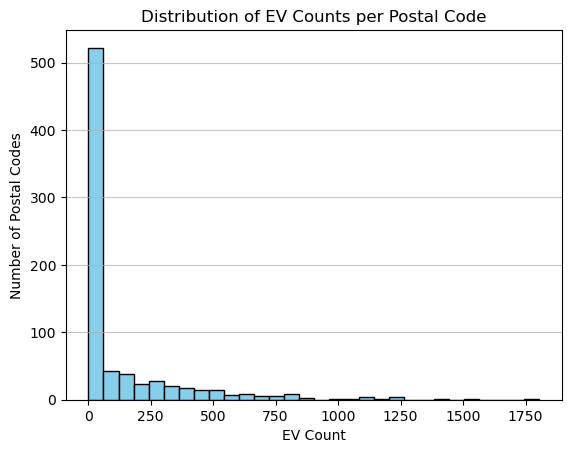

In [257]:
plt.hist(grouped['vehicle_count'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of EV Counts per Postal Code')
plt.xlabel('EV Count')
plt.ylabel('Number of Postal Codes')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [272]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
 )
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (618, 170) Test shape: (155, 170)


In [268]:
grouped = df.groupby('Postal Code').agg({
    'Model': 'count'
}).rename(columns={'Model': 'vehicle_count'})
print(grouped.head())

             vehicle_count
Postal Code               
2110.0                   1
2136.0                   1
2631.0                   1
2840.0                   1
2842.0                   2


In [269]:
bevs = df[df['Electric Vehicle Type'] == 'Battery Electric Vehicle (BEV)']
bevs_count = bevs.groupby('Postal Code').size()
grouped['bev_ratio'] = grouped['vehicle_count'].where(grouped['vehicle_count'] == 0, bevs_count / grouped['vehicle_count']).fillna(0)

print(grouped.head())

             vehicle_count  bev_ratio
Postal Code                          
2110.0                   1        0.0
2136.0                   1        1.0
2631.0                   1        1.0
2840.0                   1        0.0
2842.0                   2        0.0


In [270]:
grouped['avg_base_msrp'] = df.groupby('Postal Code')['Base MSRP'].mean().values

grouped.head()

,vehicle_count,bev_ratio,avg_base_msrp
Postal Code,,,
2110.0,1,0.0,0.0
2136.0,1,1.0,0.0
2631.0,1,1.0,0.0
2840.0,1,0.0,0.0
2842.0,2,0.0,0.0


In [271]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest R^2:", r2_score(y_test, y_pred_rf))

Random Forest R^2: 0.8925855083824862


## Model Comparison: Linear Regression and Gradient Boosting
Let's compare the performance of Linear Regression and Gradient Boosting Regressor with Random Forest.

In [243]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Linear Regression R^2:", r2_score(y_test, y_pred_lr))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)
print("Gradient Boosting R^2:", r2_score(y_test, y_pred_gbr))

Linear Regression R^2: 0.8079889392332793
Gradient Boosting R^2: 0.9251751613324133
Gradient Boosting R^2: 0.9251751613324133


## Model Comparison: XGBoost and K-Nearest Neighbors
Let's try XGBoost Regressor and K-Nearest Neighbors Regressor to see if they improve performance.

In [244]:
# XGBoost Regressor
try:
    from xgboost import XGBRegressor
    xgb = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
    xgb.fit(X_train, y_train)
    y_pred_xgb = xgb.predict(X_test)
    print("XGBoost R^2:", r2_score(y_test, y_pred_xgb))
except ImportError:
    print("XGBoost is not installed. Run 'pip install xgboost' to use it.")

# K-Nearest Neighbors Regressor
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("KNN R^2:", r2_score(y_test, y_pred_knn))




XGBoost R^2: 0.9033716320991516
KNN R^2: 0.5392711688998637


## Model Comparison: Support Vector Regressor and Decision Tree
Let's try Support Vector Regressor (SVR) and Decision Tree Regressor to see if they improve performance.

In [245]:
# Support Vector Regressor (SVR)
from sklearn.svm import SVR
svr = SVR()
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)
print("SVR R^2:", r2_score(y_test, y_pred_svr))

# Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("Decision Tree R^2:", r2_score(y_test, y_pred_dt))

SVR R^2: -0.17168370601105098
Decision Tree R^2: 0.8138106807209069


## Model Results Summary and Comparison
Let's summarize the R² scores of all models tried so far to easily compare their performance.

In [261]:
# Collect and display all model R^2 scores for comparison
results = {
    'Random Forest': r2_score(y_test, y_pred_rf) if 'y_pred_rf' in locals() else None,
    'Linear Regression': r2_score(y_test, y_pred_lr) if 'y_pred_lr' in locals() else None,
    'Gradient Boosting': r2_score(y_test, y_pred_gbr) if 'y_pred_gbr' in locals() else None,
    'XGBoost': r2_score(y_test, y_pred_xgb) if 'y_pred_xgb' in locals() else None,
    'KNN': r2_score(y_test, y_pred_knn) if 'y_pred_knn' in locals() else None,
    'SVR': r2_score(y_test, y_pred_svr) if 'y_pred_svr' in locals() else None,
    'Decision Tree': r2_score(y_test, y_pred_dt) if 'y_pred_dt' in locals() else None,
    'Extra Trees': r2_score(y_test, y_pred_et) if 'y_pred_et' in locals() else None,
    'LightGBM': r2_score(y_test, y_pred_lgbm) if 'y_pred_lgbm' in locals() else None,
    'CatBoost': r2_score(y_test, y_pred_cat) if 'y_pred_cat' in locals() else None,
}
import pandas as pd
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'R^2 Score'])
print("\nModel Comparison Table:")
print(results_df.sort_values('R^2 Score', ascending=False).to_string(index=False))


Model Comparison Table:
            Model  R^2 Score
      Extra Trees   0.956774
Gradient Boosting   0.925175
         CatBoost   0.923249
         LightGBM   0.904872
          XGBoost   0.903372
    Random Forest   0.892586
    Decision Tree   0.813811
Linear Regression   0.807989
              KNN   0.539271
              SVR  -0.171684


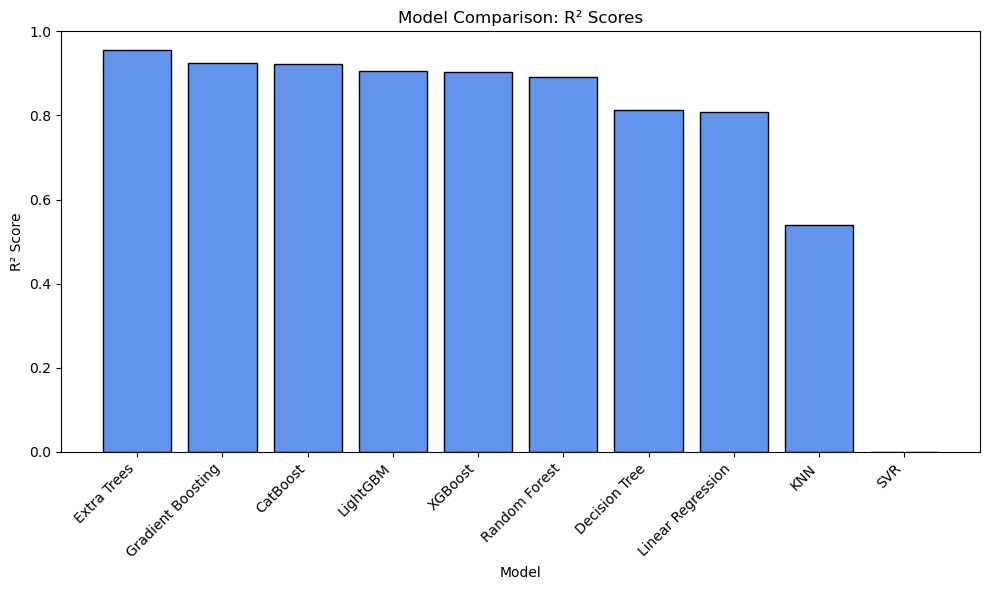

In [260]:
# Bar chart of R² scores for all models
import matplotlib.pyplot as plt
results_sorted = results_df.sort_values('R^2 Score', ascending=False)
plt.figure(figsize=(10, 6))
plt.bar(results_sorted['Model'], results_sorted['R^2 Score'], color='cornflowerblue', edgecolor='black')
plt.title('Model Comparison: R² Scores')
plt.xlabel('Model')
plt.ylabel('R² Score')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

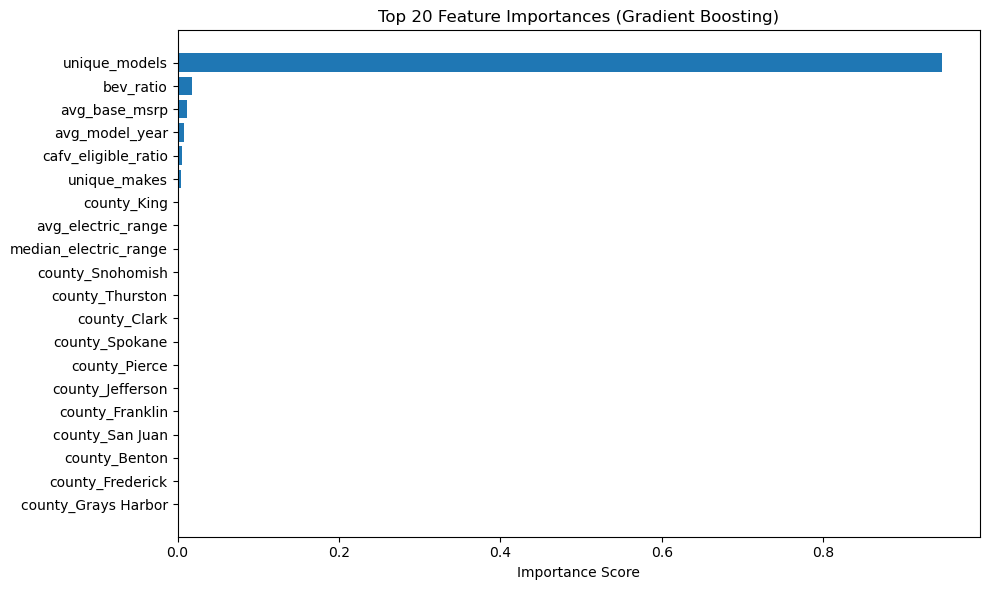


Top 20 Features by Importance (Gradient Boosting):
              Feature  Importance
        unique_models    0.946729
            bev_ratio    0.017297
        avg_base_msrp    0.011249
       avg_model_year    0.008274
  cafv_eligible_ratio    0.005980
         unique_makes    0.004732
          county_King    0.002295
   avg_electric_range    0.001502
median_electric_range    0.000607
     county_Snohomish    0.000569
      county_Thurston    0.000377
         county_Clark    0.000146
       county_Spokane    0.000140
        county_Pierce    0.000045
     county_Jefferson    0.000021
      county_Franklin    0.000016
      county_San Juan    0.000014
        county_Benton    0.000009
     county_Frederick    0.000000
  county_Grays Harbor    0.000000


In [262]:
# Feature Importance Analysis for Gradient Boosting and Random Forest
import matplotlib.pyplot as plt
import numpy as np

# Choose the best model (Gradient Boosting preferred if available)
if 'gbr' in locals():
    model = gbr
    model_name = 'Gradient Boosting'
elif 'rf' in locals():
    model = rf
    model_name = 'Random Forest'
else:
    print('No tree-based model found for feature importance analysis.')
    model = None

if model is not None:
    importances = model.feature_importances_
    feature_names = X.columns
    indices = np.argsort(importances)[::-1]
    top_n = 20  # Show top 20 features
    plt.figure(figsize=(10, 6))
    plt.title(f'Top {top_n} Feature Importances ({model_name})')
    plt.barh(range(top_n), importances[indices][:top_n][::-1], align='center')
    plt.yticks(range(top_n), [feature_names[i] for i in indices][:top_n][::-1])
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()
    # Print top features as a table
    top_features = pd.DataFrame({'Feature': feature_names[indices][:top_n], 'Importance': importances[indices][:top_n]})
    print(f'\nTop {top_n} Features by Importance ({model_name}):')
    print(top_features.to_string(index=False))

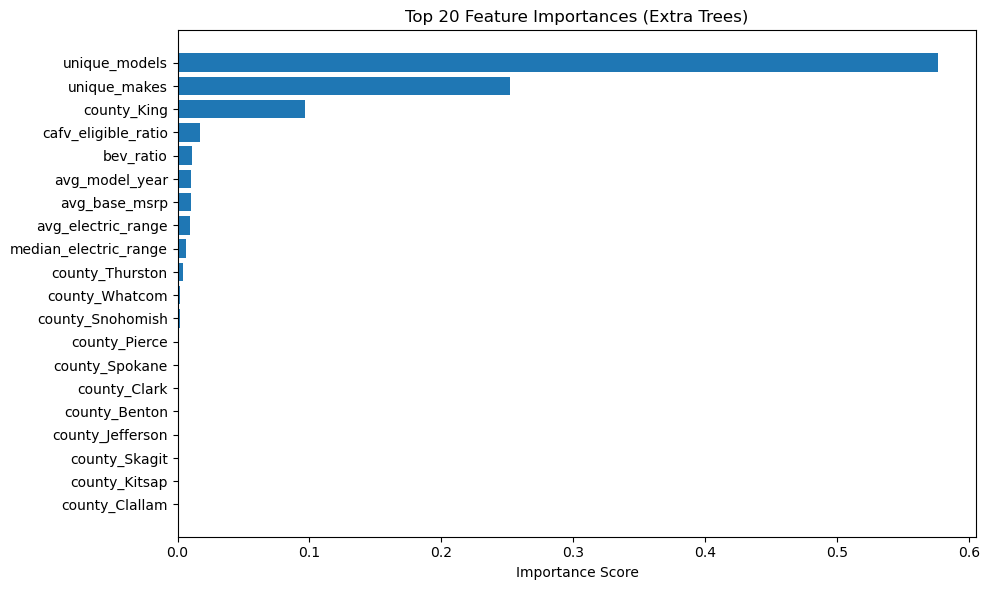


Top 20 Features by Importance (Extra Trees):
              Feature  Importance
        unique_models    0.577021
         unique_makes    0.252338
          county_King    0.096390
  cafv_eligible_ratio    0.016786
            bev_ratio    0.010902
       avg_model_year    0.010173
        avg_base_msrp    0.010083
   avg_electric_range    0.009377
median_electric_range    0.006599
      county_Thurston    0.003810
       county_Whatcom    0.001549
     county_Snohomish    0.001444
        county_Pierce    0.000892
       county_Spokane    0.000549
         county_Clark    0.000460
        county_Benton    0.000369
     county_Jefferson    0.000279
        county_Skagit    0.000266
        county_Kitsap    0.000168
       county_Clallam    0.000112


In [263]:
# Feature Importance for Extra Trees Regressor
import matplotlib.pyplot as plt
import numpy as np

if 'et' in locals():
    importances_et = et.feature_importances_
    feature_names = X.columns
    indices_et = np.argsort(importances_et)[::-1]
    top_n = 20  # Show top 20 features
    plt.figure(figsize=(10, 6))
    plt.title(f'Top {top_n} Feature Importances (Extra Trees)')
    plt.barh(range(top_n), importances_et[indices_et][:top_n][::-1], align='center')
    plt.yticks(range(top_n), [feature_names[i] for i in indices_et][:top_n][::-1])
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()
    # Print top features as a table
    top_features_et = pd.DataFrame({'Feature': feature_names[indices_et][:top_n], 'Importance': importances_et[indices_et][:top_n]})
    print(f'\nTop {top_n} Features by Importance (Extra Trees):')
    print(top_features_et.to_string(index=False))
else:
    print('Extra Trees model not found. Please run the Extra Trees training cell first.')

## Hyperparameter Tuning for Gradient Boosting Regressor

To further improve model performance, let's perform hyperparameter tuning using GridSearchCV for the Gradient Boosting Regressor. We'll search for the best combination of parameters using cross-validation.

In [248]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 4, 5],
    'subsample': [0.8, 1.0]
}

gbr_tune = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(gbr_tune, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print('Best parameters:', grid_search.best_params_)
print('Best cross-validated R^2:', grid_search.best_score_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 50, 'subsample': 1.0}
Best cross-validated R^2: 0.9185753079885313


In [249]:
# Retrain Gradient Boosting with best parameters and evaluate on test set
best_params = grid_search.best_params_
gbr_best = GradientBoostingRegressor(**best_params, random_state=42)
gbr_best.fit(X_train, y_train)
y_pred_best = gbr_best.predict(X_test)
from sklearn.metrics import r2_score, mean_squared_error
print('Test R^2:', r2_score(y_test, y_pred_best))
print('Test RMSE:', mean_squared_error(y_test, y_pred_best, squared=False))

Test R^2: 0.9090871045240051
Test RMSE: 65.75340602245036


c:\Users\Owner\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Residual/Error Analysis for the Tuned Gradient Boosting Model

Let's analyze the residuals (errors) of the tuned model to check for patterns, outliers, or systematic issues. This helps validate model assumptions and identify areas for improvement.

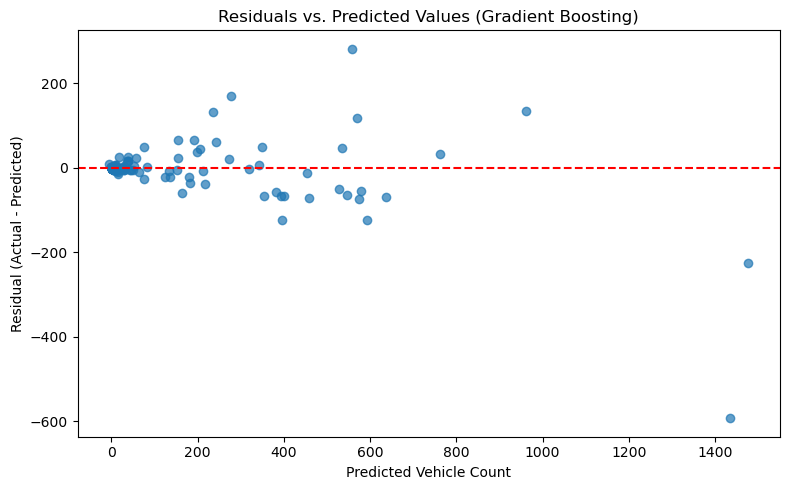

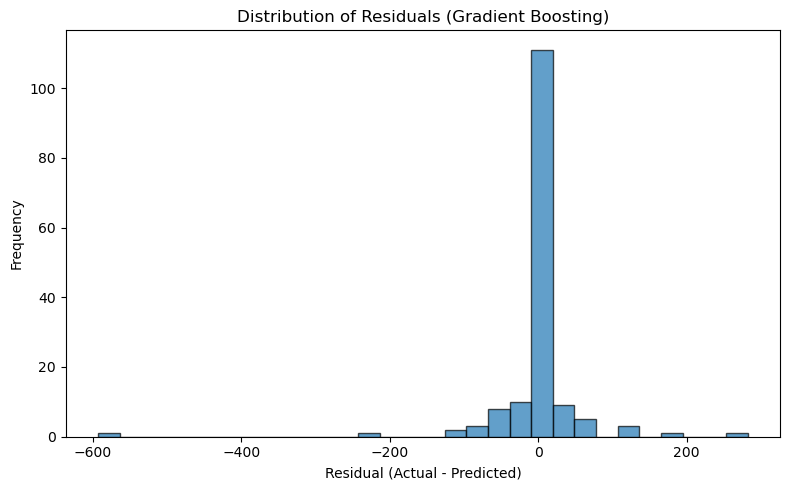

Residuals Mean: -3.4584847658793816
Residuals Std Dev: 65.66238867629924


In [250]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate residuals
residuals = y_test - y_pred_best

# Plot residuals vs. predicted values
plt.figure(figsize=(8,5))
plt.scatter(y_pred_best, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Vehicle Count')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residuals vs. Predicted Values (Gradient Boosting)')
plt.tight_layout()
plt.show()

# Plot histogram of residuals
plt.figure(figsize=(8,5))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (Gradient Boosting)')
plt.tight_layout()
plt.show()

# Print summary statistics
print('Residuals Mean:', np.mean(residuals))
print('Residuals Std Dev:', np.std(residuals))

### Actual vs. Predicted Chart for Test Set

The following chart compares the actual vehicle counts to the model's predictions for each postal code in the test set. Points close to the diagonal line indicate accurate predictions.

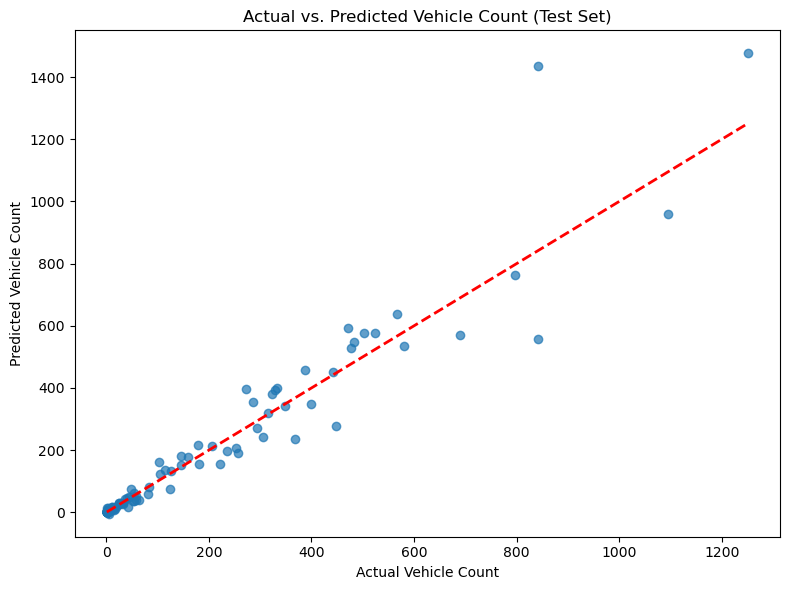

In [251]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_best, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Vehicle Count')
plt.ylabel('Predicted Vehicle Count')
plt.title('Actual vs. Predicted Vehicle Count (Test Set)')
plt.tight_layout()
plt.show()

## Trying Additional Models: LightGBM, CatBoost, and Extra Trees
Let's try three more advanced ensemble models: LightGBM, CatBoost, and Extra Trees Regressor. These often provide strong performance on tabular data.

In [252]:
# Check if train/test split variables exist and print their shapes
try:
    print('X_train shape:', X_train.shape)
    print('X_test shape:', X_test.shape)
    print('y_train shape:', y_train.shape)
    print('y_test shape:', y_test.shape)
except NameError:
    print('You need to re-run the cell where you split your data into training and test sets (train_test_split).')

X_train shape: (618, 170)
X_test shape: (155, 170)
y_train shape: (618,)
y_test shape: (155,)


In [253]:
# LightGBM Regressor
try:
    from lightgbm import LGBMRegressor
    lgbm = LGBMRegressor(n_estimators=100, random_state=42)
    lgbm.fit(X_train, y_train)
    y_pred_lgbm = lgbm.predict(X_test)
    print("LightGBM R^2:", r2_score(y_test, y_pred_lgbm))
except ImportError:
    print("LightGBM is not installed. Run '!pip install lightgbm' to use it.")

# CatBoost Regressor
try:
    from catboost import CatBoostRegressor
    cat = CatBoostRegressor(n_estimators=100, random_state=42, verbose=0)
    cat.fit(X_train, y_train)
    y_pred_cat = cat.predict(X_test)
    print("CatBoost R^2:", r2_score(y_test, y_pred_cat))
except ImportError:
    print("CatBoost is not installed. Run '!pip install catboost' to use it.")

# Extra Trees Regressor
from sklearn.ensemble import ExtraTreesRegressor
et = ExtraTreesRegressor(n_estimators=100, random_state=42)
et.fit(X_train, y_train)
y_pred_et = et.predict(X_test)
print("Extra Trees R^2:", r2_score(y_test, y_pred_et))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1011
[LightGBM] [Info] Number of data points in the train set: 618, number of used features: 13
[LightGBM] [Info] Start training from score 130.634304
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 